# Monotonic Neural Network - Joseph Sill 1997

The paper "Monotonic Networks" by Joseph Sill proposes a novel type of deep neural network that enforces a monotonic relationship between the input features and the output prediction. The main problem this paper tries to solve is the difficulty of incorporating domain knowledge into deep learning models. 

The proposed network architecture, called Monotonic Networks, allows for the integration of prior knowledge by enforcing the monotonicity constraint, which states that an increase in any input feature must result in a non-decreasing output prediction. This constraint is especially relevant in domains such as finance, healthcare, and recommendations, where monotonic relationships between features and outcomes are often present. 

The proposed method outperforms existing state-of-the-art models in several real-world datasets and offers interpretability and robustness benefits.

![](monNN.png)

Link to paper: [Monotonic Neural Networks](https://proceedings.neurips.cc/paper_files/paper/1997/file/83adc9225e4deb67d7ce42d58fe5157c-Paper.pdf)

## 0. Library imports

In [1]:
# linear algebra
import math
import numpy as np

# deep learning
import torch
import torch.nn as nn
import torch.nn.functional as F

# display
from torchview import draw_graph
from IPython.display import display
from IPython.core.display import SVG, HTML

# plot
import matplotlib.pyplot as plt
import matplotlib

# progress bar
from tqdm import tqdm

# model
from models.monNN import MonotonicNet

# functions
from functions import *

# support for automatic reloading
%load_ext autoreload
%autoreload 2

In [2]:
# make this work

# # Set random seed
# torch.manual_seed(42)
# np.random.seed(42)

# # Set device
# if (int(torch.__version__.split(".")[0]) >= 2) or (int(torch.__version__.split(".")[1]) >= 13) and torch.has_mps:
#     device = torch.device("mps")
# elif torch.cuda.is_available():
#     device = torch.device("cuda")
# else:
#     device = torch.device("cpu")

# # Set matplotlib style
# matplotlib.rcParams["figure.dpi"] = 200
# matplotlib.rcParams["font.size"] = 8

## 1. Function Examples

Let's apply the Monotonic Neural Network on different toy functions which have different properties: monotonic increasing/decreasing, 1D/2D, non-monotonic.

### 2.1 $f_1(x) = (x+1)^2$: monotonic increasing in $x$

In [3]:
# define space
X_tensor_f1 = torch.linspace(-1, 1, 1000).float()
Z1_tensor = torch.tensor(f1(X_tensor_f1)).float()

/var/folders/28/h_mscv5s3451k1q3hj4p2gxm0000gn/T/ipykernel_61103/113802178.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Z1_tensor = torch.tensor(f1(X_tensor_f1)).float()


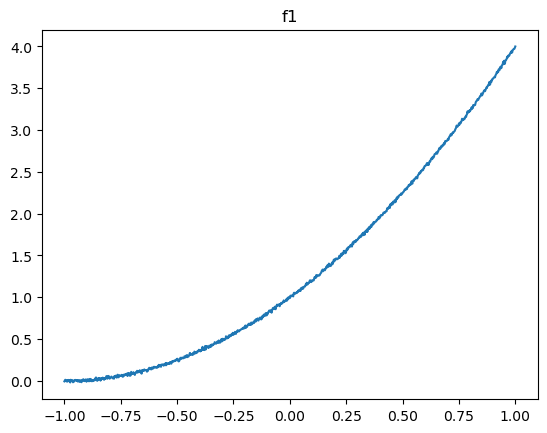

In [4]:
# plotting the function
plt.subplot(1, 1, 1)
plt.plot(X_tensor_f1.cpu().detach(), Z1_tensor.cpu().detach(), label='f1')
plt.title('f1')
plt.savefig('figures/f1.png')
plt.show()

In [5]:
# NN parameters
n_features_in = 1 # only one variable
group_size = [2, 4, 4, 2] # number of neurons in each group
increasing = [True] # increasing or decreasing

# initial learning rate
LR = 1e-2

# defining the model
model_f1 = MonotonicNet(in_features=n_features_in, group_sizes=group_size, increasing=increasing)

# defining the loss function, the optimizer and the scheduler
criterion_f1 = nn.MSELoss()
optimizer_f1 = torch.optim.Adam(model_f1.parameters(), lr=LR)
scheduler_f1 = torch.optim.lr_scheduler.StepLR(optimizer_f1, step_size=100, gamma=0.75)

n_samples_train = X_tensor_f1.shape[0]

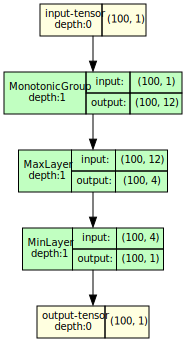

In [6]:
# Show model
try:
    from torchview import draw_graph
    from IPython.core.display import SVG
except ImportError as e:
    print(f"Install graphviz and torchview to show model graph: {e.msg}")
    graph = None
else:
    model_graph = draw_graph(model_f1, input_size=(100, n_features_in), device='cpu', save_graph=True, filename="MonNN_graph_f1", graph_dir="figures/")
    graph = SVG(model_graph.visual_graph._repr_image_svg_xml())
graph

In [7]:
# training loop
EPOCHS = 200
BATCH_SIZE = 10

losses_f1 = []

# loop through EPOCHS
for epoch in (pbar := tqdm(range(EPOCHS))):
    train_losses = []
    permutation = torch.randperm(n_samples_train)
    
    # loop through batches
    for i in range(0, n_samples_train, BATCH_SIZE):
        model_f1.train()

        # choose batch
        idx = permutation[i: i+BATCH_SIZE]
        batch_x, batch_y = X_tensor_f1[idx], Z1_tensor[idx]

        # zero grad
        optimizer_f1.zero_grad()

        # forward pass
        output = model_f1(batch_x.unsqueeze(1))

        # compute loss
        loss = criterion_f1(output, batch_y.unsqueeze(1))

        # backward pass
        loss.backward()
        train_losses.append(loss.item())

        # update weights
        optimizer_f1.step()

    # update LR
    scheduler_f1.step()

    losses_f1.append(np.mean(train_losses))

    # update progress bar
    pbar.set_description(f"Epoch {epoch: >2}")
    pbar.set_postfix_str(f"Loss {losses_f1[-1]:.7f} - LR {optimizer_f1.param_groups[0]['lr']:.7f}")
    

Epoch 199: 100%|██████████| 200/200 [00:13<00:00, 15.03it/s, Loss 0.0003968 - LR 0.0056250]


In [8]:
# prediction
with torch.no_grad():
    model_f1.eval()
    y_pred = model_f1(X_tensor_f1.unsqueeze(1))

final_loss = criterion_f1(y_pred, Z1_tensor.unsqueeze(1))

print(f"Epoch {EPOCHS} - train loss: {losses_f1[-1]}")
print(f"Epoch {EPOCHS} - test loss: {final_loss}")

Epoch 200 - train loss: 0.0003968304466252448
Epoch 200 - test loss: 0.0002971007488667965


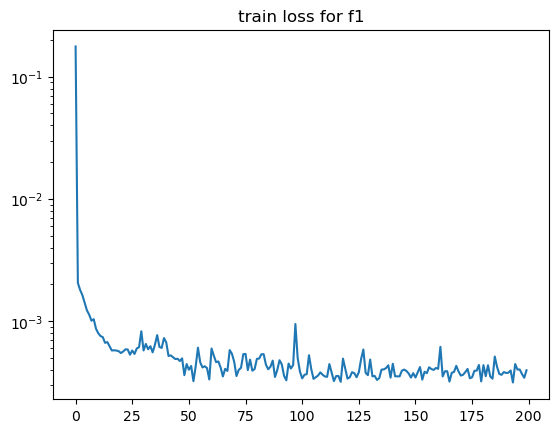

In [9]:
# plot train loss
plt.subplot(1, 1, 1)
plt.plot(losses_f1, label='train loss')
plt.yscale('log')
plt.title('train loss for f1')
plt.savefig('figures/MonNN_train_loss_f1.png')
plt.show()

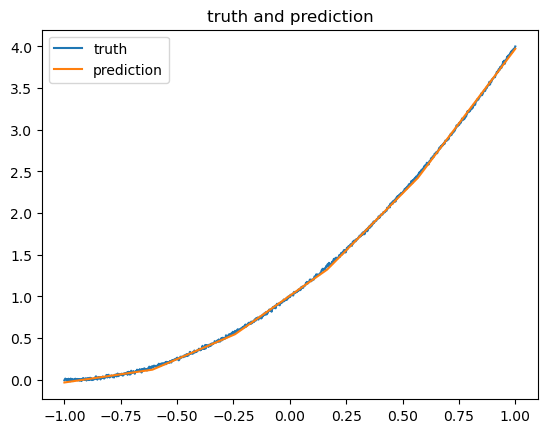

In [10]:
# plot truth and prediction on same graph for 1D function
plt.subplot(1, 1, 1)
plt.plot(X_tensor_f1, Z1_tensor, label='truth')
plt.plot(X_tensor_f1, y_pred, label='prediction')
plt.title('truth and prediction')
plt.legend()
plt.savefig('figures/MonNN_truth_prediction_f1.png')
plt.show()

### 2.2 $f_2(x) = -(x+1)^2$: monotonic decreasing in $x$

In [11]:
# define space
X_tensor_f2 = torch.linspace(-1, 1, 1000).float()
Z2_tensor = torch.tensor(f2(X_tensor_f2)).float()

/var/folders/28/h_mscv5s3451k1q3hj4p2gxm0000gn/T/ipykernel_61103/1365814033.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Z2_tensor = torch.tensor(f2(X_tensor_f2)).float()


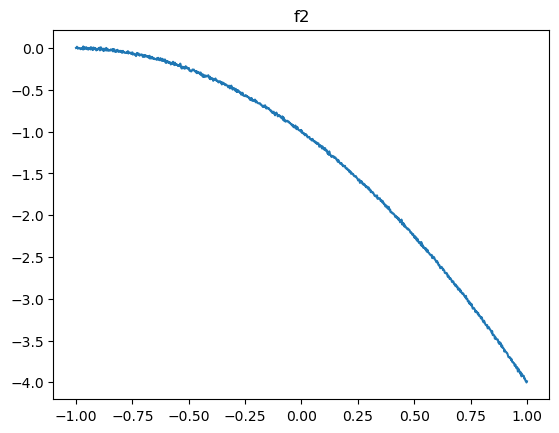

In [12]:
# plotting the function
plt.subplot(1, 1, 1)
plt.plot(X_tensor_f2.cpu().detach(), Z2_tensor.cpu().detach(), label='f2')
plt.title('f2')
plt.savefig('figures/f2.png')
plt.show()

In [13]:
# NN parameters
n_features_in = 1 # only one variable
group_size = [2, 4, 4, 2] # number of neurons in each group
increasing = [False] # increasing or decreasing

# initial learning rate
LR = 1e-2

# defining the model
model_f2 = MonotonicNet(in_features=n_features_in, group_sizes=group_size, increasing=increasing)

# defining the loss function, the optimizer and the scheduler
criterion_f2 = nn.MSELoss()
optimizer_f2 = torch.optim.Adam(model_f2.parameters(), lr=LR)
scheduler_f2 = torch.optim.lr_scheduler.StepLR(optimizer_f2, step_size=100, gamma=0.75)

n_samples_train = X_tensor_f2.shape[0]

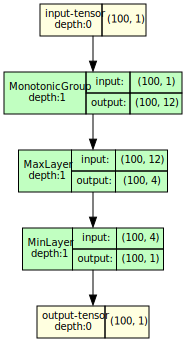

In [14]:
# Show model
try:
    from torchview import draw_graph
    from IPython.core.display import SVG
except ImportError as e:
    print(f"Install graphviz and torchview to show model graph: {e.msg}")
    graph = None
else:
    model_graph = draw_graph(model_f2, input_size=(100, n_features_in), device='cpu', save_graph=True, filename="MonNN_graph_f2", graph_dir="figures/")
    graph = SVG(model_graph.visual_graph._repr_image_svg_xml())
graph

In [15]:
# training loop
EPOCHS = 200
BATCH_SIZE = 10

losses_f2 = []

# loop through EPOCHS
for epoch in (pbar := tqdm(range(EPOCHS))):
    train_losses = []
    permutation = torch.randperm(n_samples_train)

    # loop through batches
    for i in range(0, n_samples_train, BATCH_SIZE):
        model_f2.train()

        # choose batch
        idx = permutation[i: i+BATCH_SIZE]
        batch_x, batch_y = X_tensor_f2[idx], Z2_tensor[idx]

        # zero grad
        optimizer_f2.zero_grad()

        # forward pass
        output = model_f2(batch_x.unsqueeze(1))

        # compute loss
        loss = criterion_f2(output, batch_y.unsqueeze(1))

        # backward pass
        loss.backward()
        train_losses.append(loss.item())

        # update weights
        optimizer_f2.step()

    # update LR
    scheduler_f2.step()

    losses_f2.append(np.mean(train_losses))

    # update progress bar
    pbar.set_description(f"Epoch {epoch: >2}")
    pbar.set_postfix_str(f"Loss {losses_f2[-1]:.7f} - LR {optimizer_f2.param_groups[0]['lr']:.7f}")
    

Epoch 199: 100%|██████████| 200/200 [00:15<00:00, 13.13it/s, Loss 0.0064308 - LR 0.0056250]


In [16]:
# prediction
with torch.no_grad():
    model_f2.eval()
    y_pred = model_f2(X_tensor_f2.unsqueeze(1))

final_loss = criterion_f2(y_pred, Z2_tensor.unsqueeze(1))

print(f"Epoch {EPOCHS} - train loss: {losses_f2[-1]}")
print(f"Epoch {EPOCHS} - test loss: {final_loss}")

Epoch 200 - train loss: 0.006430776652414352
Epoch 200 - test loss: 0.005897921044379473


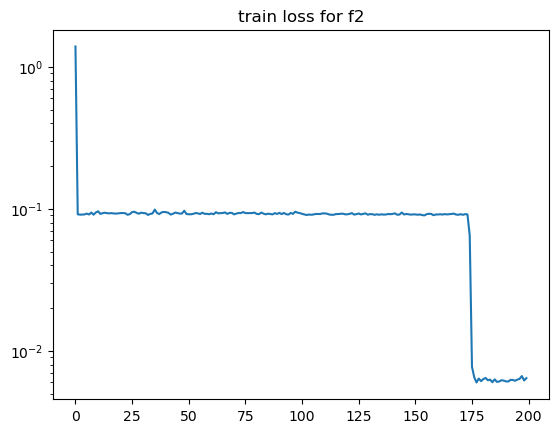

In [17]:
# plot train loss
plt.subplot(1, 1, 1)
plt.plot(losses_f2, label='train loss')
plt.yscale('log')
plt.title('train loss for f2')
plt.savefig('figures/MonNN_train_loss_f2.png')
plt.show()

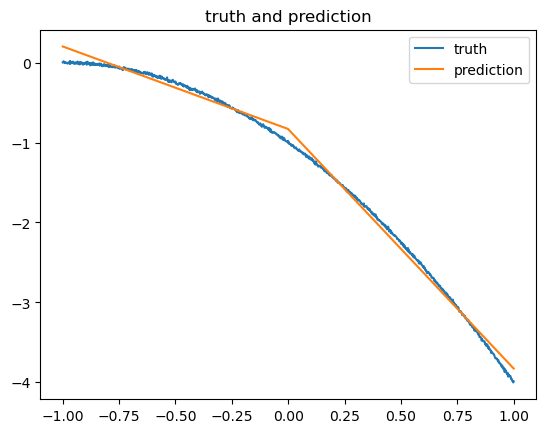

In [18]:
# plot truth and prediction on same graph for 1D function
plt.subplot(1, 1, 1)
plt.plot(X_tensor_f2, Z2_tensor, label='truth')
plt.plot(X_tensor_f2, y_pred, label='prediction')
plt.title('truth and prediction')
plt.legend()
plt.savefig('figures/MonNN_truth_prediction_f2.png')
plt.show()

### 2.3 $f_3(x, y) = x+y$: monotonic increasing in $x$ and $y$

In [19]:
# define space
X_tensor_f3 = torch.linspace(-1, 1, 100)
Y_tensor_f3 = torch.linspace(-1, 1, 100)
X_tensor_f3_2D, Y_tensor_f3_2D = torch.meshgrid(X_tensor_f3, Y_tensor_f3)
Z3_tensor_2D = torch.tensor(f3(X_tensor_f3_2D, Y_tensor_f3_2D))

/Users/ncarmona/miniconda3/envs/torch/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1678454852765/work/aten/src/ATen/native/TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/var/folders/28/h_mscv5s3451k1q3hj4p2gxm0000gn/T/ipykernel_61103/1277584719.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Z3_tensor_2D = torch.tensor(f3(X_tensor_f3_2D, Y_tensor_f3_2D))


/var/folders/28/h_mscv5s3451k1q3hj4p2gxm0000gn/T/ipykernel_61103/2477673157.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Z3_tensor = torch.tensor(Z3_tensor_2D.ravel()).float()


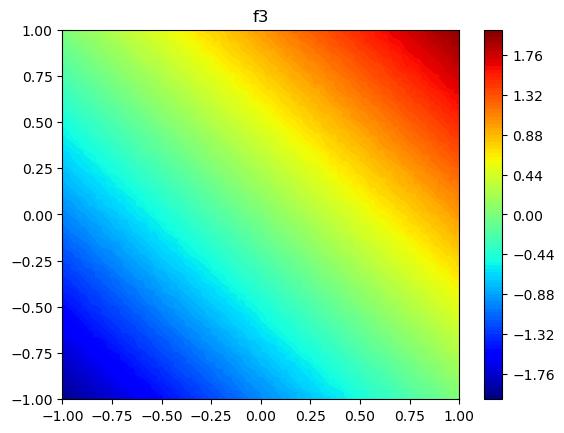

In [20]:
X_tensor_2d = torch.cat((X_tensor_f3_2D.unsqueeze(2), Y_tensor_f3_2D.unsqueeze(2)), dim=2).view(-1, 2)
Z3_tensor = torch.tensor(Z3_tensor_2D.ravel()).float()

plt.subplot(1, 1, 1)
plt.contourf(X_tensor_f3_2D, Y_tensor_f3_2D, Z3_tensor_2D, 100, cmap='jet')
plt.colorbar()
plt.title('f3')
plt.savefig('figures/f3.png')
plt.show()

In [21]:
# NN parameters
n_features_in = 2 # 2 variables in input 
group_size = [4, 8, 8, 4] # number of neurons in each group
increasing = [True, True] # increasing or decreasing

# initial learning rate
LR = 1e-2

# defining the model
model_f3 = MonotonicNet(in_features=n_features_in, group_sizes=group_size, increasing=increasing)

# defining the loss function, the optimizer and the scheduler
criterion_f3 = nn.MSELoss()
optimizer_f3 = torch.optim.Adam(model_f3.parameters(), lr=LR)
scheduler_f3 = torch.optim.lr_scheduler.StepLR(optimizer_f3, step_size=100, gamma=0.75)

n_samples_train = X_tensor_2d.shape[0]

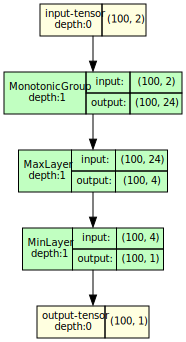

In [22]:
# Show model
try:
    from torchview import draw_graph
    from IPython.core.display import SVG
except ImportError as e:
    print(f"Install graphviz and torchview to show model graph: {e.msg}")
    graph = None
else:
    model_graph = draw_graph(model_f3, input_size=(100, n_features_in), device='cpu', save_graph=True, filename="MonNN_graph_f3", graph_dir="figures/")
    graph = SVG(model_graph.visual_graph._repr_image_svg_xml())
graph

In [23]:
# training loop
EPOCHS = 600
BATCH_SIZE = 256

losses_f3 = []

# loop through EPOCHS
for epoch in (pbar := tqdm(range(EPOCHS))):
    train_losses = []
    permutation = torch.randperm(n_samples_train)

    # loop through batches
    for i in range(0, n_samples_train, BATCH_SIZE):
        model_f3.train()

        # choose batch
        idx = permutation[i: i+BATCH_SIZE] # np.arange(i, i+BATCH_SIZE)
        batch_x, batch_y = X_tensor_2d[idx], Z3_tensor[idx]

        # zero grad
        optimizer_f3.zero_grad()

        # forward pass
        output = model_f3(batch_x)

        # compute loss
        loss = criterion_f3(output, batch_y.unsqueeze(1))

        # backward pass
        loss.backward()
        train_losses.append(loss.item())

        # update weights
        optimizer_f3.step()

    # update LR
    scheduler_f3.step()

    losses_f3.append(np.mean(train_losses))

    # update progress bar
    pbar.set_description(f"Epoch {epoch: >2}")
    pbar.set_postfix_str(f"Loss {losses_f3[-1]:.7f} - LR {optimizer_f3.param_groups[0]['lr']:.7f}")
    

Epoch 599: 100%|██████████| 600/600 [00:27<00:00, 21.77it/s, Loss 0.0001113 - LR 0.0017798]


In [24]:
# prediction
with torch.no_grad():
    model_f3.eval()
    y_pred = model_f3(X_tensor_2d)

final_loss = criterion_f3(y_pred, Z3_tensor.unsqueeze(1))

print(f"Epoch {EPOCHS} - train loss: {losses_f3[-1]}")
print(f"Epoch {EPOCHS} - test loss: {final_loss}")

Epoch 600 - train loss: 0.00011133497646369506
Epoch 600 - test loss: 0.0001391117984894663


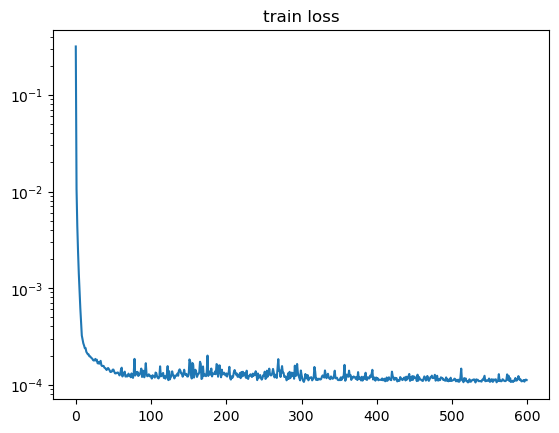

In [25]:
# plot train loss
plt.subplot(1, 1, 1)
plt.plot(losses_f3, label='train loss')
plt.yscale('log')
plt.title('train loss')
plt.savefig('figures/MonNN_train_loss_f3.png')
plt.show()

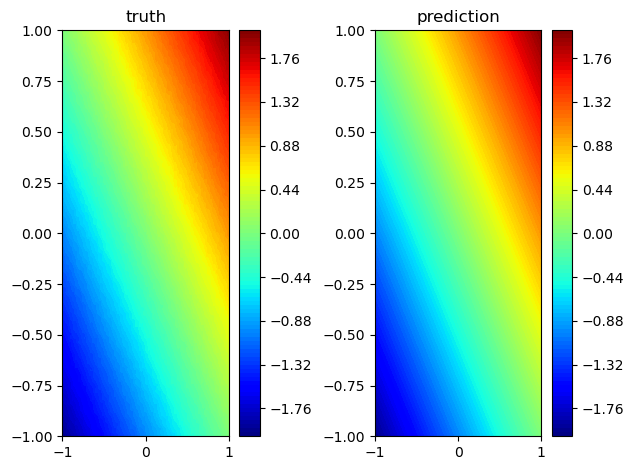

In [26]:
# plot truth and prediction side by side
plt.subplot(1, 2, 1)
plt.contourf(X_tensor_f3_2D, Y_tensor_f3_2D, Z3_tensor_2D, 100, cmap='jet')
plt.colorbar()
plt.title('truth')

plt.subplot(1, 2, 2)
plt.contourf(X_tensor_f3_2D, Y_tensor_f3_2D, y_pred.view(100, 100).detach().numpy(), 100, cmap='jet')
plt.colorbar()
plt.title('prediction')

plt.tight_layout()

plt.savefig('figures/MonNN_truth_prediction_f3.png')
plt.show()

### 2.4 $f_4(x, y) = x-y$: monotonic increasing in $x$, decreasing in $y$ 

In [27]:
# define space
X_tensor_f4 = torch.linspace(-1, 1, 100)
Y_tensor_f4 = torch.linspace(-1, 1, 100)
X_tensor_f4_2D, Y_tensor_f4_2D = torch.meshgrid(X_tensor_f4, Y_tensor_f4)
Z4_tensor_2D = torch.tensor(f4(X_tensor_f4_2D, Y_tensor_f4_2D))

/var/folders/28/h_mscv5s3451k1q3hj4p2gxm0000gn/T/ipykernel_61103/3655634531.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Z4_tensor_2D = torch.tensor(f4(X_tensor_f4_2D, Y_tensor_f4_2D))


/var/folders/28/h_mscv5s3451k1q3hj4p2gxm0000gn/T/ipykernel_61103/3922313273.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Z4_tensor = torch.tensor(Z4_tensor_2D.ravel()).float()


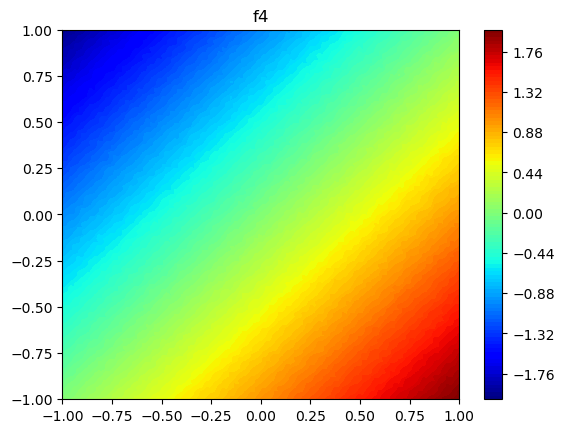

In [28]:
X_tensor_2d = torch.cat((X_tensor_f4_2D.unsqueeze(2), Y_tensor_f4_2D.unsqueeze(2)), dim=2).view(-1, 2)
Z4_tensor = torch.tensor(Z4_tensor_2D.ravel()).float()

plt.subplot(1, 1, 1)
plt.contourf(X_tensor_f4_2D, Y_tensor_f4_2D, Z4_tensor_2D, 100, cmap='jet')
plt.colorbar()
plt.title('f4')
plt.savefig('figures/f4.png')
plt.show()

In [29]:
# NN parameters
n_features_in = 2 # 2 variables in put
group_size = [4, 8, 8, 4] # number of neurons in each group
increasing = [True, False] # increasing or decreasing

# initial learning rate
LR = 1e-2

# defining the model
model_f4 = MonotonicNet(in_features=n_features_in, group_sizes=group_size, increasing=increasing)

# defining the loss function, the optimizer and the scheduler
criterion_f4 = nn.MSELoss()
optimizer_f4 = torch.optim.Adam(model_f4.parameters(), lr=LR)
scheduler_f4 = torch.optim.lr_scheduler.StepLR(optimizer_f4, step_size=100, gamma=0.75)

n_samples_train = X_tensor_2d.shape[0]

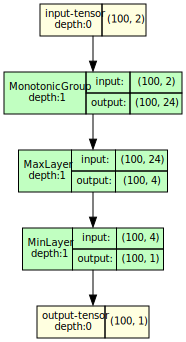

In [30]:
# Show model
try:
    from torchview import draw_graph
    from IPython.core.display import SVG
except ImportError as e:
    print(f"Install graphviz and torchview to show model graph: {e.msg}")
    graph = None
else:
    model_graph = draw_graph(model_f4, input_size=(100, n_features_in), device='cpu', save_graph=True, filename="MonNN_graph_f4", graph_dir="figures/")
    graph = SVG(model_graph.visual_graph._repr_image_svg_xml())
graph

In [31]:
# training loop
EPOCHS = 500
BATCH_SIZE = 256

losses_f4 = []

# loop through EPOCHS
for epoch in (pbar := tqdm(range(EPOCHS))):
    train_losses = []
    permutation = torch.randperm(n_samples_train)

    # loop through batches
    for i in range(0, n_samples_train, BATCH_SIZE):
        model_f4.train()

        # choose batch
        idx = permutation[i: i+BATCH_SIZE]
        batch_x, batch_y = X_tensor_2d[idx], Z4_tensor[idx]

        # zero grad
        optimizer_f4.zero_grad()

        # forward pass
        output = model_f4(batch_x)

        # compute loss
        loss = criterion_f4(output, batch_y.unsqueeze(1))

        # backward pass
        loss.backward()
        train_losses.append(loss.item())

        # update weights
        optimizer_f4.step()

    # update LR
    scheduler_f4.step()

    losses_f4.append(np.mean(train_losses))

    # update progress bar
    pbar.set_description(f"Epoch {epoch: >2}")
    pbar.set_postfix_str(f"Loss {losses_f4[-1]:.7f} - LR {optimizer_f4.param_groups[0]['lr']:.7f}")
    

Epoch 499: 100%|██████████| 500/500 [00:25<00:00, 19.58it/s, Loss 0.0001075 - LR 0.0023730]


In [32]:
# prediction
with torch.no_grad():
    model_f4.eval()
    y_pred = model_f4(X_tensor_2d)

final_loss = criterion_f4(y_pred, Z4_tensor.unsqueeze(1))

print(f"Epoch {EPOCHS} - train loss: {losses_f4[-1]}")
print(f"Epoch {EPOCHS} - test loss: {final_loss}")

Epoch 500 - train loss: 0.0001075143700290937
Epoch 500 - test loss: 0.00011038149386877194


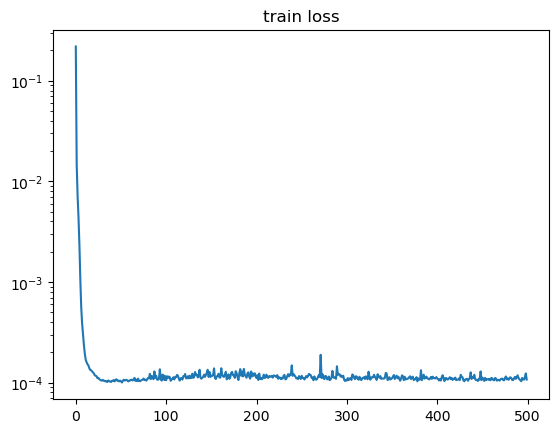

In [33]:
# plot train loss
plt.subplot(1, 1, 1)
plt.plot(losses_f4, label='train loss')
plt.yscale('log')
plt.title('train loss')
plt.savefig('figures/MonNN_train_loss_f4.png')
plt.show()

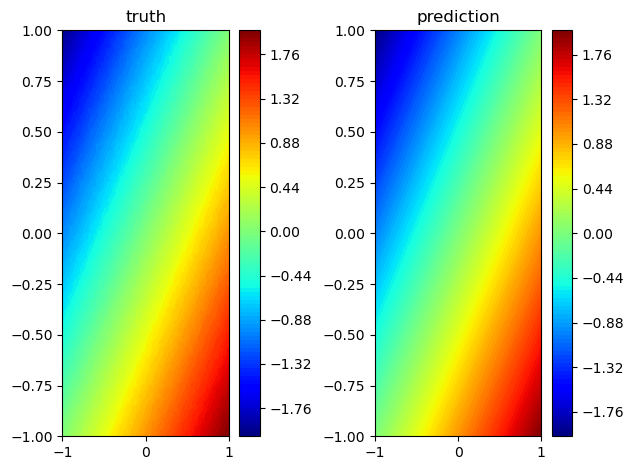

In [34]:
# plot truth and prediction side by side
plt.subplot(1, 2, 1)
plt.contourf(X_tensor_f4_2D, Y_tensor_f4_2D, Z4_tensor_2D, 100, cmap='jet')
plt.colorbar()
plt.title('truth')

plt.subplot(1, 2, 2)
plt.contourf(X_tensor_f4_2D, Y_tensor_f4_2D, y_pred.view(100, 100).detach().numpy(), 100, cmap='jet')
plt.colorbar()
plt.title('prediction')

plt.tight_layout()

plt.savefig('figures/MonNN_truth_prediction_f4.png')

plt.show()

### 2.5 $f(x) = cos(x)$: non-monotonic 

In [35]:
# define space
X_tensor_f5 = torch.linspace(-1, 1, 1000).float()
Z5_tensor = torch.tensor(f5(X_tensor_f5)).float()

/var/folders/28/h_mscv5s3451k1q3hj4p2gxm0000gn/T/ipykernel_61103/2979234019.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Z5_tensor = torch.tensor(f5(X_tensor_f5)).float()


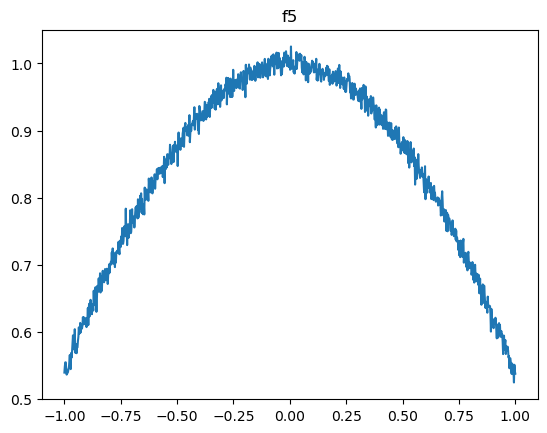

In [36]:
# plotting the function
plt.subplot(1, 1, 1)
plt.plot(X_tensor_f5.cpu().detach(), Z5_tensor.cpu().detach(), label='f5')
plt.title('f5')
plt.savefig('figures/f5.png')
plt.show()

In [37]:
# NN parameters
n_features_in = 1 # only one variable
group_size = [4, 8, 8, 4] # number of neurons in each group
increasing = [True] # increasing or decreasing

# initial learning rate
LR = 1e-2

# defining the model
model_f5 = MonotonicNet(in_features=n_features_in, group_sizes=group_size, increasing=increasing)

# defining the loss function, the optimizer and the scheduler
criterion_f5 = nn.MSELoss()
optimizer_f5 = torch.optim.Adam(model_f5.parameters(), lr=LR)
scheduler_f5 = torch.optim.lr_scheduler.StepLR(optimizer_f5, step_size=100, gamma=0.75)

n_samples_train = X_tensor_f5.shape[0]

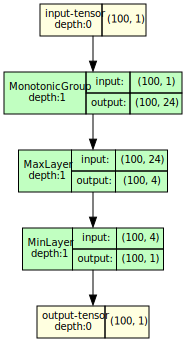

In [38]:
# Show model
try:
    from torchview import draw_graph
    from IPython.core.display import SVG
except ImportError as e:
    print(f"Install graphviz and torchview to show model graph: {e.msg}")
    graph = None
else:
    model_graph = draw_graph(model_f5, input_size=(100, n_features_in), device='cpu', save_graph=True, filename="MonNN_graph_f5", graph_dir="figures/")
    graph = SVG(model_graph.visual_graph._repr_image_svg_xml())
graph

In [39]:
# training loop
EPOCHS = 500
BATCH_SIZE = 10

losses_f5 = []

# loop through EPOCHS
for epoch in (pbar := tqdm(range(EPOCHS))):
    train_losses = []
    permutation = torch.randperm(n_samples_train)

    # loop through batches
    for i in range(0, n_samples_train, BATCH_SIZE):
        model_f5.train()

        # choose batch
        idx = permutation[i: i+BATCH_SIZE]
        batch_x, batch_y = X_tensor_f5[idx], Z5_tensor[idx]

        # zero grad
        optimizer_f5.zero_grad()

        # forward pass
        output = model_f5(batch_x.unsqueeze(1))

        # compute loss
        loss = criterion_f5(output, batch_y.unsqueeze(1))

        # backward pass
        loss.backward()
        train_losses.append(loss.item())

        # update weights
        optimizer_f5.step()

    # update LR
    scheduler_f5.step()

    losses_f5.append(np.mean(train_losses))

    # update progress bar
    pbar.set_description(f"Epoch {epoch: >2}")
    pbar.set_postfix_str(f"Loss {losses_f5[-1]:.7f} - LR {optimizer_f5.param_groups[0]['lr']:.7f}")
    

Epoch 499: 100%|██████████| 500/500 [00:40<00:00, 12.46it/s, Loss 0.0001650 - LR 0.0023730]


In [40]:
# prediction
with torch.no_grad():
    model_f5.eval()
    y_pred = model_f5(X_tensor_f5.unsqueeze(1))

final_loss = criterion_f5(y_pred, Z5_tensor.unsqueeze(1))

print(f"Epoch {EPOCHS} - train loss: {losses_f5[-1]}")
print(f"Epoch {EPOCHS} - test loss: {final_loss}")

Epoch 500 - train loss: 0.00016502748763741693
Epoch 500 - test loss: 0.00017757242312654853


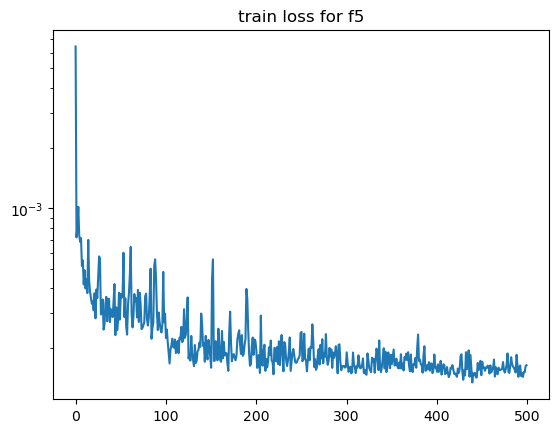

In [41]:
# plot train loss
plt.subplot(1, 1, 1)
plt.plot(losses_f5, label='train loss')
plt.yscale('log')
plt.title('train loss for f5')
plt.savefig('figures/MonNN_train_loss_f5.png')
plt.show()

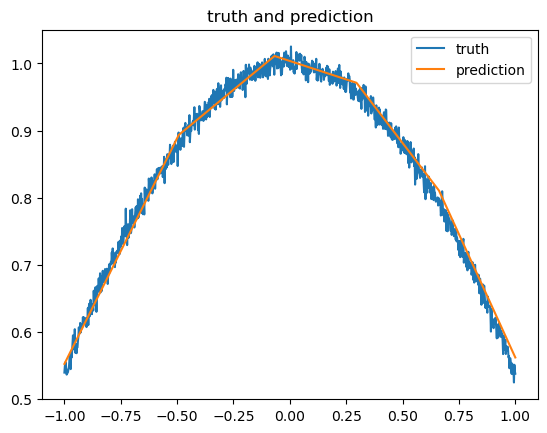

In [42]:
# plot truth and prediction on same graph for 1D function
plt.subplot(1, 1, 1)
plt.plot(X_tensor_f5, Z5_tensor, label='truth')
plt.plot(X_tensor_f5, y_pred, label='prediction')
plt.title('truth and prediction')
plt.legend()
plt.savefig('figures/MonNN_truth_prediction_f5.png')
plt.show()

### 2.6 $f_6(x, y) = x^2 + y^2$: monotonic increasing in $x$ and $y$

In [43]:
# define space
X_tensor_f6 = torch.linspace(0, 1, 100)
Y_tensor_f6 = torch.linspace(0, 1, 100)
X_tensor_f6_2D, Y_tensor_f6_2D = torch.meshgrid(X_tensor_f6, Y_tensor_f6)
Z6_tensor_2D = torch.tensor(f6(X_tensor_f6_2D, Y_tensor_f6_2D))

/var/folders/28/h_mscv5s3451k1q3hj4p2gxm0000gn/T/ipykernel_61103/1986257368.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Z6_tensor_2D = torch.tensor(f6(X_tensor_f6_2D, Y_tensor_f6_2D))


/var/folders/28/h_mscv5s3451k1q3hj4p2gxm0000gn/T/ipykernel_61103/1579358041.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Z6_tensor = torch.tensor(Z6_tensor_2D.ravel()).float()


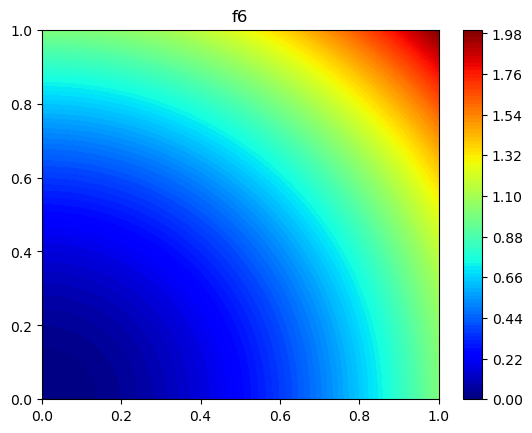

In [44]:
X_tensor_2d = torch.cat((X_tensor_f6_2D.unsqueeze(2), Y_tensor_f6_2D.unsqueeze(2)), dim=2).view(-1, 2)
Z6_tensor = torch.tensor(Z6_tensor_2D.ravel()).float()

# plotting the function
plt.subplot(1, 1, 1)
plt.contourf(X_tensor_f6_2D, Y_tensor_f6_2D, Z6_tensor_2D, 100, cmap='jet')
plt.colorbar()
plt.title('f6')
plt.savefig('figures/f6.png')
plt.show()

In [45]:
# NN parameters
n_features_in = 2 # 2 variables in input
group_size = [4, 8, 16, 16, 8, 4] # number of neurons in each group
increasing = [True, True] # increasing or decreasing

# initial learning rate
LR = 1e-2

# defining the model
model_f6 = MonotonicNet(in_features=n_features_in, group_sizes=group_size, increasing=increasing)

# defining the loss function, the optimizer and the scheduler
criterion_f6 = nn.MSELoss()
optimizer_f6 = torch.optim.Adam(model_f6.parameters(), lr=LR)
scheduler_f6 = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_f6, T_max=100, eta_min=1e-6)

n_samples_train = X_tensor_2d.shape[0]

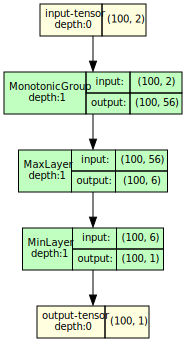

In [46]:
# Show model
try:
    from torchview import draw_graph
    from IPython.core.display import SVG
except ImportError as e:
    print(f"Install graphviz and torchview to show model graph: {e.msg}")
    graph = None
else:
    model_graph = draw_graph(model_f6, input_size=(100, n_features_in), device='cpu', save_graph=True, filename="MonNN_graph_f6", graph_dir="figures/")
    graph = SVG(model_graph.visual_graph._repr_image_svg_xml())
graph

In [47]:
# training loop
EPOCHS = 500
BATCH_SIZE = 256

losses_f6 = []

# loop through EPOCHS
for epoch in (pbar := tqdm(range(EPOCHS))):
    train_losses = []
    permutation = torch.randperm(n_samples_train)

    # loop through batches
    for i in range(0, n_samples_train, BATCH_SIZE):
        model_f6.train()

        # choose batch
        idx = permutation[i: i+BATCH_SIZE]
        batch_x, batch_y = X_tensor_2d[idx], Z6_tensor[idx]

        # zero grad
        optimizer_f6.zero_grad()

        # forward pass
        output = model_f6(batch_x)

        # compute loss
        loss = criterion_f6(output, batch_y.unsqueeze(1))

        # backward pass
        loss.backward()
        train_losses.append(loss.item())

        # update weights
        optimizer_f6.step()

    # update LR
    scheduler_f6.step()

    losses_f6.append(np.mean(train_losses))

    # update progress bar
    pbar.set_description(f"Epoch {epoch: >2}")
    pbar.set_postfix_str(f"Loss {losses_f6[-1]:.7f} - LR {optimizer_f6.param_groups[0]['lr']:.7f}")
    

Epoch 499: 100%|██████████| 500/500 [00:27<00:00, 17.90it/s, Loss 0.0007261 - LR 0.0000010]


In [48]:
# prediction
with torch.no_grad():
    model_f6.eval()
    y_pred = model_f6(X_tensor_2d)

final_loss = criterion_f6(y_pred, Z6_tensor.unsqueeze(1))

print(f"Epoch {EPOCHS} - train loss: {losses_f6[-1]}")
print(f"Epoch {EPOCHS} - test loss: {final_loss}")

Epoch 500 - train loss: 0.0007261116712470539
Epoch 500 - test loss: 0.0007215086370706558


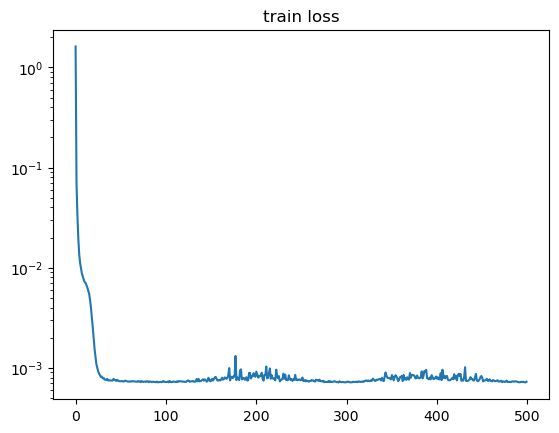

In [49]:
# plot train loss
plt.subplot(1, 1, 1)
plt.plot(losses_f6, label='train loss')
plt.yscale('log')
plt.title('train loss')
plt.savefig('figures/MonNN_train_loss_f6.png')
plt.show()

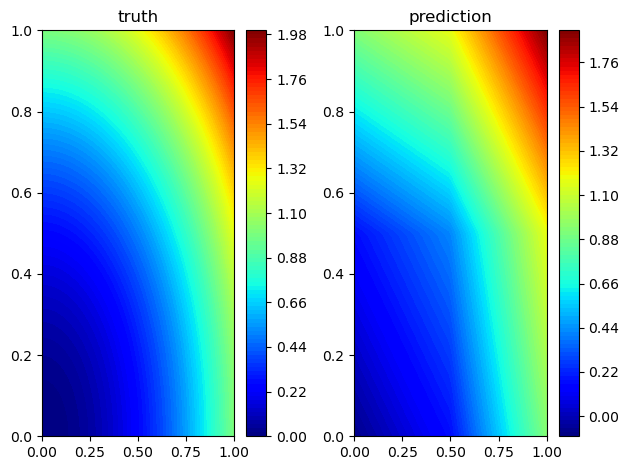

In [50]:
# plot truth and prediction side by side
plt.subplot(1, 2, 1)
plt.contourf(X_tensor_f6_2D, Y_tensor_f6_2D, Z6_tensor_2D, 100, cmap='jet')
plt.colorbar()
plt.title('truth')

plt.subplot(1, 2, 2)
plt.contourf(X_tensor_f6_2D, Y_tensor_f6_2D, y_pred.view(100, 100).detach().numpy(), 100, cmap='jet')
plt.colorbar()
plt.title('prediction')

plt.tight_layout()

plt.savefig('figures/MonNN_truth_prediction_f6.png')
plt.show()

### 2.7 $f_7(x, y) = x^3 + 0.5*sin(4*\pi*y)$: monotonic increasing in $x$ and non-monotonic in $y$

In [51]:
# define space
X_tensor_f7 = torch.linspace(-1, 1, 100)
Y_tensor_f7 = torch.linspace(-1, 1, 100)
X_tensor_f7_2D, Y_tensor_f7_2D = torch.meshgrid(X_tensor_f7, Y_tensor_f7)
Z7_tensor_2D = torch.tensor(f7(X_tensor_f7_2D, Y_tensor_f7_2D))

/var/folders/28/h_mscv5s3451k1q3hj4p2gxm0000gn/T/ipykernel_61103/1626095358.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Z7_tensor_2D = torch.tensor(f7(X_tensor_f7_2D, Y_tensor_f7_2D))


/var/folders/28/h_mscv5s3451k1q3hj4p2gxm0000gn/T/ipykernel_61103/4246487071.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Z7_tensor = torch.tensor(Z7_tensor_2D.ravel()).float()


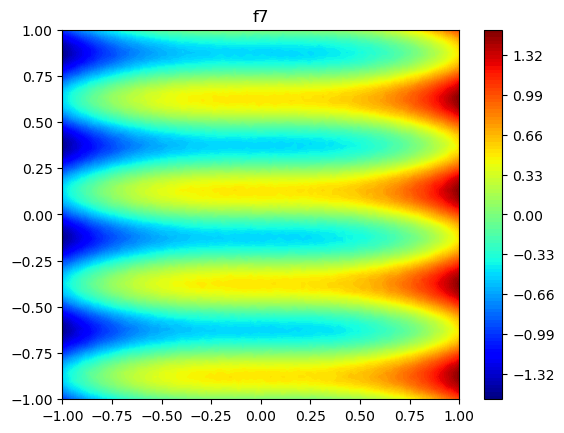

In [52]:
X_tensor_2d = torch.cat((X_tensor_f7_2D.unsqueeze(2), Y_tensor_f7_2D.unsqueeze(2)), dim=2).view(-1, 2)
Z7_tensor = torch.tensor(Z7_tensor_2D.ravel()).float()

# plotting the function
plt.subplot(1, 1, 1)
plt.contourf(X_tensor_f7_2D, Y_tensor_f7_2D, Z7_tensor_2D, 100, cmap='jet')
plt.colorbar()
plt.title('f7')
plt.savefig('figures/f7.png')
plt.show()

In [53]:
# NN parameters
n_features_in = 2 
group_size = [8, 16, 32, 32, 64, 32, 32, 16, 8]
increasing = [True, False]

# initial learning rate
LR = 1e-2

# defining the model
model_f7 = MonotonicNet(in_features=n_features_in, group_sizes=group_size, increasing=increasing)

# defining the loss function, the optimizer and the scheduler
criterion_f7 = nn.MSELoss()
optimizer_f7 = torch.optim.Adam(model_f7.parameters(), lr=LR)

# cosine scheduler
scheduler_f7 = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_f7, T_max=100, eta_min=1e-6)
n_samples_train = X_tensor_2d.shape[0]

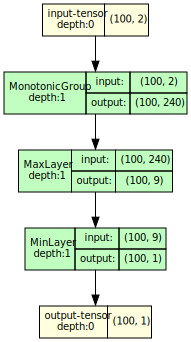

In [54]:
# Show model
try:
    from torchview import draw_graph
    from IPython.core.display import SVG
except ImportError as e:
    print(f"Install graphviz and torchview to show model graph: {e.msg}")
    graph = None
else:
    model_graph = draw_graph(model_f7, input_size=(100, n_features_in), device='cpu', save_graph=True, filename="MonNN_graph_f7", graph_dir="figures/")
    graph = SVG(model_graph.visual_graph._repr_image_svg_xml())
graph

In [55]:
# training loop
EPOCHS = 1_000
BATCH_SIZE = 256

losses_f7 = []

# loop through EPOCHS
for epoch in (pbar := tqdm(range(EPOCHS))):
    train_losses = []
    permutation = torch.randperm(n_samples_train)

    # loop through batches
    for i in range(0, n_samples_train, BATCH_SIZE):
        model_f7.train()

        # choose batch
        idx = permutation[i: i+BATCH_SIZE]
        batch_x, batch_y = X_tensor_2d[idx], Z7_tensor[idx]

        # zero grad
        optimizer_f7.zero_grad()

        # forward pass
        output = model_f7(batch_x)

        # compute loss
        loss = criterion_f7(output, batch_y.unsqueeze(1))

        # backward pass
        loss.backward()
        train_losses.append(loss.item())

        # update weights
        optimizer_f7.step()

    # update LR
    scheduler_f7.step()

    losses_f7.append(np.mean(train_losses))

    # update progress bar
    pbar.set_description(f"Epoch {epoch: >2}")
    pbar.set_postfix_str(f"Loss {losses_f7[-1]:.7f} - LR {optimizer_f7.param_groups[0]['lr']:.7f}")
    

Epoch 999: 100%|██████████| 1000/1000 [01:48<00:00,  9.20it/s, Loss 0.0137073 - LR 0.0100000]


In [56]:
# prediction
with torch.no_grad():
    model_f7.eval()
    y_pred = model_f7(X_tensor_2d)

final_loss = criterion_f7(y_pred, Z7_tensor.unsqueeze(1))

print(f"Epoch {EPOCHS} - train loss: {losses_f7[-1]}")
print(f"Epoch {EPOCHS} - test loss: {final_loss}")

Epoch 1000 - train loss: 0.013707291975151747
Epoch 1000 - test loss: 0.013046051375567913


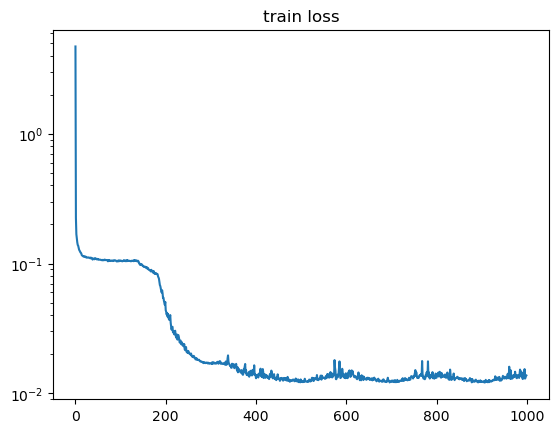

In [57]:
# plot train loss
plt.subplot(1, 1, 1)
plt.plot(losses_f7, label='train loss')
plt.yscale('log')
plt.title('train loss')
plt.savefig('figures/MonNN_train_loss_f7.png')
plt.show()

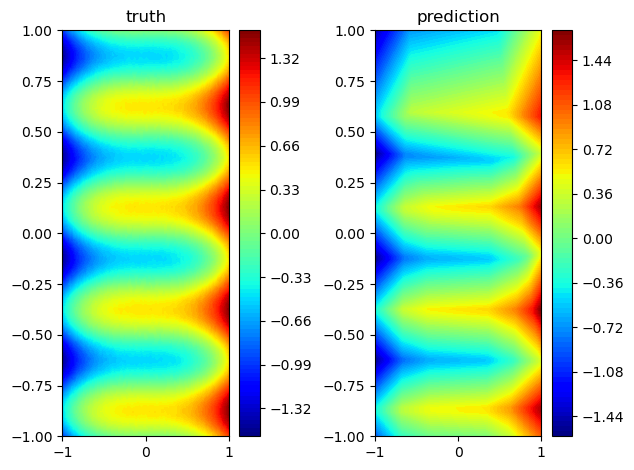

In [58]:
# plot truth and prediction side by side
plt.subplot(1, 2, 1)
plt.contourf(X_tensor_f7_2D, Y_tensor_f7_2D, Z7_tensor_2D, 100, cmap='jet')
plt.colorbar()
plt.title('truth')

plt.subplot(1, 2, 2)
plt.contourf(X_tensor_f7_2D, Y_tensor_f7_2D, y_pred.view(100, 100).detach().numpy(), 100, cmap='jet')
plt.colorbar()
plt.title('prediction')

plt.tight_layout()

plt.savefig('figures/MonNN_truth_prediction_f7.png')
plt.show()